In [ ]:
import os
import random
import math
from PIL import Image, ImageOps, ImageFilter

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from tensorflow.keras.utils import load_img, img_to_array

import kagglehub
import matplotlib.pyplot as plt

from warnings import filterwarnings
from IPython.display import clear_output
from tqdm import tqdm

filterwarnings('ignore')

In [ ]:
def save_to_drive(filepath):
    !cp -r $filepath drive/MyDrive/Colab/170/

DATASETS_FOLDER = "datasets"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
'''
#####
Adapted from https://github.com/facebookresearch/barlowtwins
and mostly taken from https://github.com/MaxLikesMath/Barlow-Twins-Pytorch
#####
'''


class GaussianBlur(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            sigma = random.random() * 1.9 + 0.1
            return img.filter(ImageFilter.GaussianBlur(sigma))
        else:
            return img


class Solarization(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img


class Transform:
    def __init__(self, transform=None, transform_prime=None):
        '''

        :param transform: Transforms to be applied to first input
        :param transform_prime: transforms to be applied to second
        '''
        if transform == None:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(224, interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=1.0),
                Solarization(p=0.0),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform
        if transform_prime == None:

            self.transform_prime = transforms.Compose([
                transforms.RandomResizedCrop(224, interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=0.1),
                Solarization(p=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform_prime = transform_prime

    def __call__(self, x):
        y1 = self.transform(x)
        y2 = self.transform_prime(x)
        return torch.cat((y1.unsqueeze(0), y2.unsqueeze(0)))


In [ ]:
'''
Implementation of Barlow Twins (https://arxiv.org/abs/2103.03230), adapted for ease of use for experiments from
https://github.com/facebookresearch/barlowtwins, with some modifications using code from
https://github.com/lucidrains/byol-pytorch

Mostly taken from https://github.com/MaxLikesMath/Barlow-Twins-Pytorch
'''

def flatten(t):
    return t.reshape(t.shape[0], -1)

class NetWrapper(nn.Module):
    # from https://github.com/lucidrains/byol-pytorch
    def __init__(self, net, layer = -2):
        super().__init__()
        self.net = net
        self.layer = layer

        self.hidden = None
        self.hook_registered = False

    def _find_layer(self):
        if type(self.layer) == str:
            modules = dict([*self.net.named_modules()])
            return modules.get(self.layer, None)
        elif type(self.layer) == int:
            children = [*self.net.children()]
            return children[self.layer]
        return None

    def _hook(self, _, __, output):
        self.hidden = flatten(output)

    def _register_hook(self):
        layer = self._find_layer()
        assert layer is not None, f'hidden layer ({self.layer}) not found'
        handle = layer.register_forward_hook(self._hook)
        self.hook_registered = True

    def get_representation(self, x):
        if self.layer == -1:
            return self.net(x)

        if not self.hook_registered:
            self._register_hook()

        _ = self.net(x)
        hidden = self.hidden
        self.hidden = None
        assert hidden is not None, f'hidden layer {self.layer} never emitted an output'
        return hidden

    def forward(self, x):
        representation = self.get_representation(x)

        return representation


def off_diagonal(x):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()


class BarlowTwins(nn.Module):
    '''
    Adapted from https://github.com/facebookresearch/barlowtwins for arbitrary backbones, and arbitrary choice of whic  h
    latent representation to use. Designed for models which can fit on a single GPU (though training can be parallelized
    across multiple as with any other model). Support for larger models can be done easily for individual use cases by
    by following PyTorch's model parallelism best practices.
    '''
    def __init__(self, backbone, latent_id, projection_sizes, lambd, scale_factor=1):
        '''

        :param backbone: Model backbone
        :param latent_id: name (or index) of the layer to be fed to the projection MLP
        :param projection_sizes: size of the hidden layers in the projection MLP
        :param lambd: tradeoff function
        :param scale_factor: Factor to scale loss by, default is 1
        '''
        super().__init__()
        self.backbone = backbone
        self.backbone = NetWrapper(self.backbone, latent_id)
        self.lambd = lambd
        self.scale_factor = scale_factor
        # projector
        sizes = projection_sizes
        layers = []
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=False))
            layers.append(nn.BatchNorm1d(sizes[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        if len(sizes) >= 2:
          layers.append(nn.Linear(sizes[-2], sizes[-1], bias=False))
        self.projector = nn.Sequential(*layers)

        # normalization layer for the representations z1 and z2
        self.bn = nn.BatchNorm1d(sizes[-1], affine=False)

    def forward(self, y1, y2):
        z1 = self.backbone(y1)
        z2 = self.backbone(y2)
        z1 = self.projector(z1)
        z2 = self.projector(z2)

        # empirical cross-correlation matrix
        c = torch.mm(self.bn(z1).T, self.bn(z2))
        c.div_(z1.shape[0])

        # use --scale-loss to multiply the loss by a constant factor
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss = self.scale_factor*(on_diag + self.lambd * off_diag)
        return loss

    def adjust_learning_rate(self, optimizer, epoch, epochs):
        start_lr = 5e-3
        end_lr = 5e-4

        coef = 0.5 * (1 + math.cos(math.pi * epoch / epochs))
        lr = start_lr * coef + end_lr * (1 - coef)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    def train_head(self, train_dataloader, validation_dataloader,
                   optimizer, epochs=20):
        '''
        Training projector with frozen backbone's weights

        train_dataloader: dataloader for train samples
        validation_dataloader: dataloader for validation samples
        optimizer: gradient descent optimizer
        '''
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        print("Training on", device)
        self.backbone.requires_grad_(False)
        train_losses = []
        validation_losses = []
        for epoch in tqdm(range(epochs)):
            total_train_loss = 0
            for batch_idx, x in enumerate(train_dataloader):
                x = x.to(device)
                x1 = x[:, 0, :, :, :]
                x2 = x[:, 1, :, :, :]
                loss = self.forward(x1, x2)
                total_train_loss = (total_train_loss * batch_idx + loss.item()) / (batch_idx + 1)
                self.adjust_learning_rate(optimizer, epoch, epochs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            total_validation_loss = 0
            for batch_idx, x in enumerate(validation_dataloader):
                x = x.to(device)
                x1 = x[:, 0, :, :, :]
                x2 = x[:, 1, :, :, :]
                loss = self.forward(x1, x2)
                total_validation_loss = (total_validation_loss * batch_idx + loss.item()) / (batch_idx + 1)
            if epoch == 0:
                continue
            train_losses.append(total_train_loss)
            validation_losses.append(total_validation_loss)
            clear_output()
            plt.figure(figsize=(10, 6))
            plt.plot(train_losses, color='blue', label="train")
            plt.plot(validation_losses, color='orange', label="validation")
            plt.title("Training head")
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid(True)
            plt.legend()
            plt.show()
        return train_losses, validation_losses


In [ ]:
class ImageDataset(Dataset):
    '''
    Simple torch dataset class for images
    '''
    def __init__(self, image_array, transform=None):
        self.image_array = image_array
        self.transform = transform

    def __len__(self):
        return len(self.image_array)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.image_array[idx])
        return self.image_array[idx]


def load_images(folder_path, count):
    '''
    Loads images from the folder
    and store them as a list of PIL images
    '''
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    images = []
    folder_path = DATASETS_FOLDER + "/" + folder_path
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(file_path).convert('RGB')
            img_tensor = transform(img)
            images.append(img_tensor)
        if len(images) == count:
            break
    return images


def download_blood_cells_dataset():
    '''
    Downloads blood cells dataset
    https://www.kaggle.com/datasets/paultimothymooney/blood-cells
    Stores it locally in DATASETS_FOLDER

    Name: 'blood-cells'
    '''
    if not os.path.exists(DATASETS_FOLDER + "/blood-cells"):
        print("Downloading blood-cells dataset")
        download_path = kagglehub.dataset_download("paultimothymooney/blood-cells")
        print("Download path:", download_path)
        !cp -r $download_path $DATASETS_FOLDER
        !cp -r $DATASETS_FOLDER/6/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE $DATASETS_FOLDER
        !mv $DATASETS_FOLDER/LYMPHOCYTE $DATASETS_FOLDER/blood-cells
        !rm -r $DATASETS_FOLDER/6 $download_path
        print("Finished")
    else:
        print("Found local blood-cells dataset")



In [ ]:
resnet_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')

barlow_twins = BarlowTwins(resnet_model, 'avgpool', [2048, 1024, 1024],
                      3.9e-3, 1)


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


## Experiment: Blood Cells Dataset

### Training model head (256 images, 180 epochs)

Train: 256 images

Validation: 64 images


In [ ]:
download_blood_cells_dataset()
blood_cells_images = load_images("blood-cells", 256 + 64)

for i in range(len(blood_cells_images)):
    blood_cells_images[i] = to_pil_image(blood_cells_images[i])

blood_cells_train = blood_cells_images[:256]
blood_cells_validation = blood_cells_images[256:]

train_dataset = ImageDataset(blood_cells_train,
                       transform=Transform())
validation_dataset = ImageDataset(blood_cells_validation,
                       transform=Transform())

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)


Found local blood-cells dataset


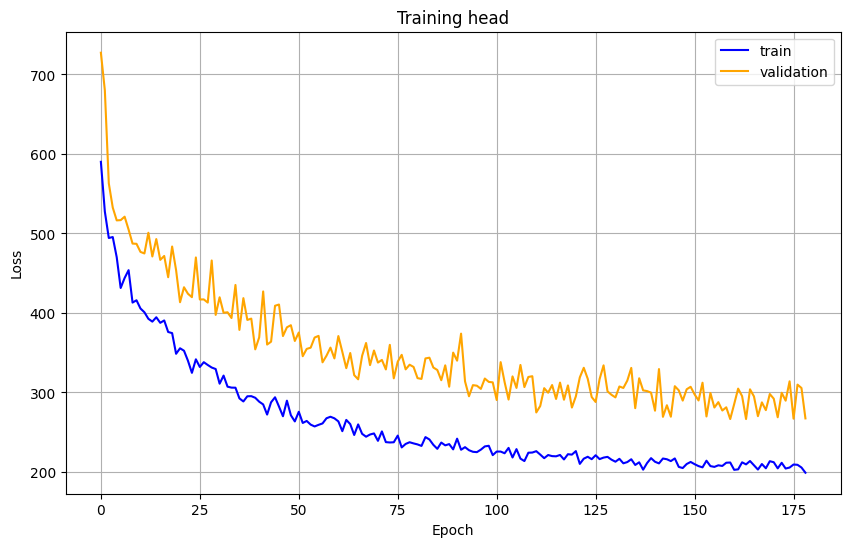

100%|██████████| 180/180 [22:07<00:00,  7.37s/it]


In [ ]:
optimizer = torch.optim.Adam(barlow_twins.parameters())

train_losses, validation_losses = barlow_twins.train_head(
    train_dataloader,
    validation_dataloader,
    optimizer,
    epochs=180
)


In [ ]:
'''
torch.save(barlow_twins.state_dict(), "BT_blood-cells-256_180ep.pth")
np.save("BT_blood-cells-256_0-180ep_train_loss", train_losses)
np.save("BT_blood-cells-256_0-180ep_validation_loss", validation_losses)

save_to_drive("BT_blood-cells-256_180ep.pth")
save_to_drive("BT_blood-cells-256_0-180ep_train_loss.npy")
save_to_drive("BT_blood-cells-256_0-180ep_validation_loss.npy")
'''

In [ ]:
'''
plt.figure(figsize=(12, 7))

plt.plot(train_losses, color='blue', label='Train')
plt.plot(validation_losses, color='orange', label='Validation')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.tick_params(labelsize=12)

plt.grid(True)
plt.legend(fontsize=14)
plt.show()
'''